# Проект для «Викишоп» с BERT

Интернет-магазин «Викишоп» запускает новый сервис. Теперь пользователи могут редактировать и дополнять описания товаров, как в вики-сообществах. То есть клиенты предлагают свои правки и комментируют изменения других. Магазину нужен инструмент, который будет искать токсичные комментарии и отправлять их на модерацию. 

Обучите модель классифицировать комментарии на позитивные и негативные. В вашем распоряжении набор данных с разметкой о токсичности правок.

Постройте модель со значением метрики качества *F1* не меньше 0.75. 

**Инструкция по выполнению проекта**

1. Загрузите и подготовьте данные.
2. Обучите разные модели. 
3. Сделайте выводы.

Для выполнения проекта применять *BERT* необязательно, но вы можете попробовать.

**Описание данных**

Данные находятся в файле `toxic_comments.csv`. Столбец *text* в нём содержит текст комментария, а *toxic* — целевой признак.

## Подготовка

In [ ]:
pip install torch

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
pip install pipeline

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
pip install nltk

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import pandas as pd
import numpy as np
import time
import seaborn as sns
from matplotlib import pyplot as plt

from sklearn.utils import shuffle

from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.dummy import DummyClassifier

import re 
import nltk
from nltk.corpus import stopwords as nltk_stopwords
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score

import torch
import transformers
from tqdm import notebook
from tqdm.notebook import tqdm

from transformers import AutoTokenizer, AutoModelForMaskedLM, AutoModel

import nltk
nltk.download('wordnet')
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('omw-1.4')
from nltk.stem import WordNetLemmatizer 

from sklearn.pipeline import Pipeline

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


In [ ]:
sns.set(style="darkgrid")

In [ ]:
data = pd.read_csv('toxic_comments.csv')
display(data)

In [ ]:
print(data.isna().sum()) 

Unnamed: 0    0
text          0
toxic         0
dtype: int64


In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 159292 entries, 0 to 159291
Data columns (total 3 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   Unnamed: 0  159292 non-null  int64 
 1   text        159292 non-null  object
 2   toxic       159292 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 3.6+ MB


**Вывод:**
    Данные в столбце text содержат текст комментария, а toxic — целевой признак. 
    Данные не содержат пропусков.

### Лемматизация текста

In [ ]:
corpus = list(data['text'])
#display(corpus)

In [ ]:
lemmatizer = WordNetLemmatizer()

In [ ]:
from nltk.corpus import wordnet
def get_wordnet_pos(word):
    tag = nltk.pos_tag([word])[0][1][0].upper()
    tag_dict = {"J": wordnet.ADJ,
                "N": wordnet.NOUN,
                "V": wordnet.VERB,
                "R": wordnet.ADV}
    return tag_dict.get(tag, wordnet.NOUN)

In [ ]:
def clear_text(text):
    cl_text = text.lower()
    cl_text = re.sub(r'[^a-zA-Z]', ' ', str(cl_text))
    cl_text = ' '.join(cl_text.split())
    return cl_text

In [ ]:
tqdm.pandas()

In [ ]:
%%time
def lemmatize(text):
    k=[]
    for w in nltk.word_tokenize(text):
        y=lemmatizer.lemmatize(w, get_wordnet_pos(w))
        k.append(y)
    return ' '.join(k) 

data['lemm_text'] = data['text'].progress_apply(clear_text)
data['lemm_text'] = data['lemm_text'].progress_apply(lemmatize)

  0%|          | 0/159292 [00:00<?, ?it/s]

  0%|          | 0/159292 [00:00<?, ?it/s]

CPU times: user 24min 25s, sys: 1min 41s, total: 26min 7s
Wall time: 26min 59s


In [ ]:
print("Исходный текст:", corpus[0])
print("Очищенный и лемматизированный текст:", lemmatize(clear_text(corpus[0])))

Исходный текст: Explanation
Why the edits made under my username Hardcore Metallica Fan were reverted? They weren't vandalisms, just closure on some GAs after I voted at New York Dolls FAC. And please don't remove the template from the talk page since I'm retired now.89.205.38.27
Очищенный и лемматизированный текст: explanation why the edits make under my username hardcore metallica fan be revert they weren t vandalism just closure on some gas after i vote at new york doll fac and please don t remove the template from the talk page since i m retire now


In [ ]:
display(data)

,Unnamed: 0,text,toxic,lemm_text
0,0,Explanation\nWhy the edits made under my usern...,0,explanation why the edits make under my userna...
1,1,D'aww! He matches this background colour I'm s...,0,d aww he match this background colour i m seem...
2,2,"Hey man, I'm really not trying to edit war. It...",0,hey man i m really not try to edit war it s ju...
3,3,"""\nMore\nI can't make any real suggestions on ...",0,more i can t make any real suggestion on impro...
4,4,"You, sir, are my hero. Any chance you remember...",0,you sir be my hero any chance you remember wha...
...,...,...,...,...
159287,159446,""":::::And for the second time of asking, when ...",0,and for the second time of ask when your view ...
159288,159447,You should be ashamed of yourself \n\nThat is ...,0,you should be ashamed of yourself that be a ho...
159289,159448,"Spitzer \n\nUmm, theres no actual article for ...",0,spitzer umm there no actual article for prosti...
159290,159449,And it looks like it was actually you who put ...,0,and it look like it be actually you who put on...


0    0.898388
1    0.101612
Name: toxic, dtype: float64


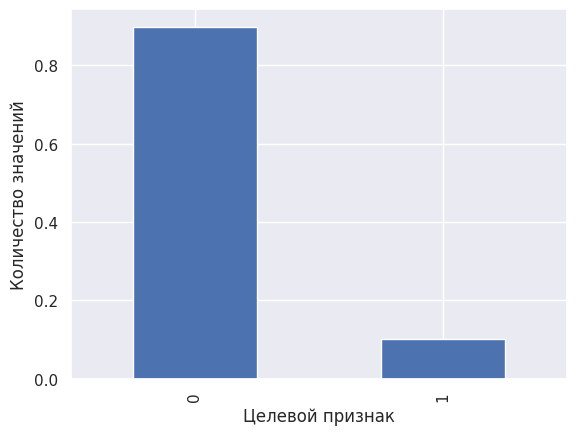

In [ ]:
class_frequency = data['toxic'].value_counts(normalize=True)
print(class_frequency)
class_frequency.plot(kind='bar')
plt.xlabel('Целевой признак')
plt.ylabel('Количество значений');

**Вывод:**  
    Была проведена очистка текста, лемматизация.  
    Глядя на распределение целевого признака видно, что данные не сбалансированы. Необходимо произвести балансировку данных.

## Обучение

### Подготовка данных к обучению

In [ ]:
RANDOM_STATE = 123456

In [ ]:
train, test = train_test_split(data, shuffle=False, test_size=0.10)

### Поиск параметров модели через PipeLine Logistic Regression

In [ ]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [ ]:
pipeline = Pipeline(
    [
        ("vect", TfidfVectorizer(stop_words='english')),
        ("lr", LogisticRegression(random_state=RANDOM_STATE, max_iter=200,  class_weight='balanced', solver='liblinear'))
    ]
)
pipeline

Pipeline(steps=[('vect', TfidfVectorizer(stop_words='english')),
                ('lr',
                 LogisticRegression(class_weight='balanced', max_iter=200,
                                    random_state=123456, solver='liblinear'))])

In [ ]:
param_grid_pipeline = {'lr__C': [0.1, 1, 10, 100]}
start_l  = time.time()
lr_grid_pipeline = GridSearchCV(estimator=pipeline, param_grid = param_grid_pipeline, cv=3, scoring='f1')
lr_grid_pipeline.fit(train['lemm_text'], train['toxic'])
end_l = time.time()
time_search_lr_pipeline = end_l - start_l
print('Гиперпараметры лучшей модели:', lr_grid_pipeline.best_params_)
print('Время поиска гиперпараметров: {:.3f}'.format(time_search_lr_pipeline))
print('Значение F1 для лучшей модели LogisticRegression: {:.2f}'.format(lr_grid_pipeline.best_score_))    

Гиперпараметры лучшей модели: {'lr__C': 10}
Время поиска гиперпараметров: 161.202
Значение F1 для лучшей модели LogisticRegression: 0.76


In [ ]:
features_train = train.drop(['Unnamed: 0', 'text','toxic'], axis=1)
target_train = train['toxic']

features_test = test.drop(['Unnamed: 0', 'text','toxic'], axis=1)
target_test = test['toxic']

In [ ]:
count_tf_idf = TfidfVectorizer(stop_words='english') 
tf_idf_features_train = count_tf_idf.fit_transform(train['lemm_text']) 
tf_idf_features_test = count_tf_idf.transform(test['lemm_text'])
print("Размер матриц:", tf_idf_features_train.shape, tf_idf_features_test.shape)

Размер матриц: (143362, 142254) (15930, 142254)


In [ ]:
lr_final = lr_grid_pipeline.best_estimator_
lr_final.fit(train['lemm_text'], target_train)

Pipeline(steps=[('vect', TfidfVectorizer(stop_words='english')),
                ('lr',
                 LogisticRegression(C=10, class_weight='balanced', max_iter=200,
                                    random_state=123456, solver='liblinear'))])

In [ ]:
print(lr_grid_pipeline.best_estimator_)

Pipeline(steps=[('vect', TfidfVectorizer(stop_words='english')),
                ('lr',
                 LogisticRegression(C=10, class_weight='balanced', max_iter=200,
                                    random_state=123456, solver='liblinear'))])


In [ ]:
lr_final = LogisticRegression (random_state=RANDOM_STATE, class_weight='balanced', C = 10, solver='liblinear')

In [ ]:
lr_final.fit(tf_idf_features_train, target_train)

LogisticRegression(C=10, class_weight='balanced', random_state=123456,
                   solver='liblinear')

### Тестирование модели LogisticRegression c Pipeline

In [ ]:
start_p = time.time() 
predictions_test_lg = lr_final.predict(tf_idf_features_test)
end_p  = time.time()
time_predict_lg = end_p - start_p
result = f1_score(target_test, predictions_test_lg)
print('Значение F1 для лучшей модели LogisticRegression на тестовой выборке {:.2f}'.format(result))
print('Время предсказания {:.3f}'.format(time_predict_lg))

Значение F1 для лучшей модели LogisticRegression на тестовой выборке 0.76
Время предсказания 0.003


### BERT

In [ ]:
display(data)

,Unnamed: 0,text,toxic,lemm_text
0,0,Explanation\nWhy the edits made under my usern...,0,explanation why the edits make under my userna...
1,1,D'aww! He matches this background colour I'm s...,0,d aww he match this background colour i m seem...
2,2,"Hey man, I'm really not trying to edit war. It...",0,hey man i m really not try to edit war it s ju...
3,3,"""\nMore\nI can't make any real suggestions on ...",0,more i can t make any real suggestion on impro...
4,4,"You, sir, are my hero. Any chance you remember...",0,you sir be my hero any chance you remember wha...
...,...,...,...,...
159287,159446,""":::::And for the second time of asking, when ...",0,and for the second time of ask when your view ...
159288,159447,You should be ashamed of yourself \n\nThat is ...,0,you should be ashamed of yourself that be a ho...
159289,159448,"Spitzer \n\nUmm, theres no actual article for ...",0,spitzer umm there no actual article for prosti...
159290,159449,And it looks like it was actually you who put ...,0,and it look like it be actually you who put on...


In [ ]:
data_bert = data.sample(600).reset_index(drop=True) 
data_bert = data_bert.drop(['Unnamed: 0', 'text'], axis=1)
display(data_bert)

,toxic,lemm_text
0,0,insure ensure i quite agree that ensure be typ...
1,0,consider this infinite time off on wiki talk
2,1,be bale turn around and told you he felt more ...
3,0,all userboxes move to user ubx s space now the...
4,0,afd sock hi tenpoundhammer i be in the midst o...
...,...,...
595,0,user dominotree gnaa member rucas the name may...
596,0,do you know elonka be a fembot
597,0,that wasn t me that ip a well a be proxy ip s ...
598,0,there be external link only one be of wikibook...


In [ ]:
model = AutoModel.from_pretrained("unitary/toxic-bert")
tokenizer = AutoTokenizer.from_pretrained("unitary/toxic-bert")

Some weights of the model checkpoint at unitary/toxic-bert were not used when initializing BertModel: ['classifier.weight', 'classifier.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [ ]:
tokenized = data_bert['lemm_text'].apply(lambda x: tokenizer.encode(x, add_special_tokens=True, max_length=512, truncation=True))

max_len = 0
for i in tokenized.values:
    if len(i) > max_len:
        max_len = len(i)

padded = np.array([i + [0]*(max_len - len(i)) for i in tokenized.values])

attention_mask = np.where(padded != 0, 1, 0)

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = model.to(device)

In [ ]:
batch_size = 100
embeddings = []
for i in notebook.tqdm(range(padded.shape[0] // batch_size)):
       batch = torch.LongTensor(padded[batch_size*i:batch_size*(i+1)]) 
       attention_mask_batch = torch.LongTensor(attention_mask[batch_size*i:batch_size*(i+1)])
       
       with torch.no_grad():
           batch_embeddings = model(batch.to(device), attention_mask=attention_mask_batch.to(device))

       embeddings.append(batch_embeddings[0][:,0,:].cpu().numpy())

  0%|          | 0/6 [00:00<?, ?it/s]

In [ ]:
features_bert = np.concatenate(embeddings)

In [ ]:
target_bert = data_bert['toxic']
print(features_bert)

[[-0.47788683 -0.6697571   0.5408953  ... -0.82886755  0.44393378
   0.17834581]
 [-0.4100468  -0.85848105  0.64573693 ... -0.7432636   0.5277302
   0.29765284]
 [-0.14882264 -0.32940665 -1.003367   ... -0.17566627 -0.18538557
   0.00528697]
 ...
 [-0.38785717 -0.6226146   0.68433315 ... -0.9402154   0.7557474
   0.30566952]
 [-0.3224989  -0.69697255  0.8177622  ... -0.9218241   0.65198463
   0.38916427]
 [-0.5185874  -0.47196057  0.11958764 ... -0.5416481   0.19423048
   1.2126328 ]]


In [ ]:
features_train_bert, features_test_bert, target_train_bert, target_test_bert = train_test_split(features_bert, target_bert, shuffle=False, test_size=0.2)

In [ ]:
model = LogisticRegression(random_state=RANDOM_STATE, class_weight='balanced',  solver='liblinear')
parametrs_lr = { 'C': range (5, 10)}
start_l  = time.time()
lr_grid = GridSearchCV(model, parametrs_lr, scoring='f1', cv=3)
lr_grid.fit(features_bert, target_bert)     
end_l = time.time()
time_search_lr = end_l - start_l
print('Гиперпараметры лучшей модели:', lr_grid.best_params_)
print('Время поиска гиперпараметров: {:.3f}'.format(time_search_lr))
print('Значение F1 для лучшей модели LogisticRegression: {:.2f}'.format(lr_grid.best_score_))      

Гиперпараметры лучшей модели: {'C': 5}
Время поиска гиперпараметров: 2.485
Значение F1 для лучшей модели LogisticRegression: 0.88


### Тестирование модели LogisticRegression c BERT

In [ ]:
lr_final_bert =  LogisticRegression (random_state=RANDOM_STATE, class_weight='balanced', C = 5, solver='liblinear')

In [ ]:
lr_final_bert.fit(features_train_bert, target_train_bert)

LogisticRegression(C=5, class_weight='balanced', random_state=123456,
                   solver='liblinear')

In [ ]:
start_p = time.time() 
predictions_test_lr = lr_final_bert.predict(features_test_bert)
end_p  = time.time()
time_predict_lr = end_p - start_p
result = f1_score(target_test_bert, predictions_test_lr)
print('Значение F1 для лучшей модели LogisticRegression на тестовой выборке {:.2f}'.format(result))
print('Время предсказания {:.3f}'.format(time_predict_lr))

Значение F1 для лучшей модели LogisticRegression на тестовой выборке 0.94
Время предсказания 0.006


## Выводы

1) Данные в столбце text содержат текст комментария, а toxic — целевой признак. Данные не содержат пропусков.  
2) Была проведена очистка текста, лемматизация, векторизация.  
3) Была построена модель LogisticRegression   
4) Наилучшее значение F1 для лучшей модели LogisticRegression 0,76 - удовлетворяет условию задачи.   
5) Тестирование проведено на лучшей модели LogisticRegression с гиперпараметрами: {C=10, class_weight='balanced', random_state=123456, solver='liblinear'}. На тестовой выбоке значение F1 для лучшей модели LogisticRegression составляет 0.76.  
6) Была постоена модель LogisticRegression с параметрами {C=5, class_weight='balanced', random_state=123456, solver='liblinear'} с использованием Bert. Значение F1 для лучшей модели LogisticRegression: 0.88. На тестовой выборке значение достигает 0.94
